In [2]:
import warnings
import os
# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)
%load_ext autoreload
%autoreload 2
os.chdir('..')
os.getcwd()

'/raid/infolab/prateekg/work/algorithmic_recourse'

In [3]:
import pickle
import torch
import utils
import data.utils as dutils
import matplotlib.pyplot as plt

import recourse.utils as rutils
from sklearn.neighbors import LocalOutlierFactor
from recourse.genre import GenRe

In [4]:
import models.binnedpm as bpm

In [5]:
exp_config = utils.load_config('results/exp1_config.yaml')

----------------------------- Executing for Dataset compas-all -----------------------------
[INFO] loaded ann model from /raid/infolab/prateekg/work/algorithmic_recourse/saved_models/classifiers/compas-all/ann_rf_tt_mm_cali_10_10_10


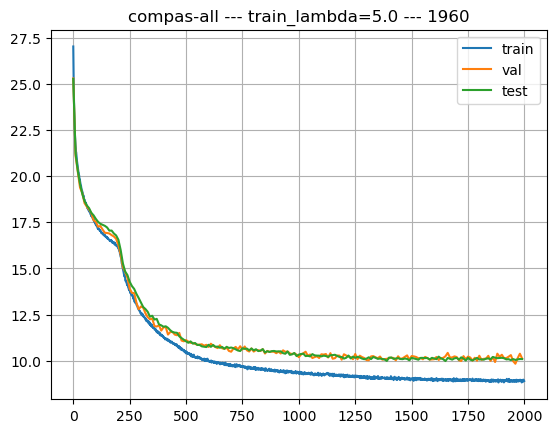

200
compas-all --- train_lambda=5.0
lof 0.97±0.17
hval gold classifier 0.99±0.10
sval gold classifier 0.75±0.10
hval ann 1.00±0.00
cost 0.51±0.18
----------------------------- Executing for Dataset heloc -----------------------------
[INFO] loaded ann model from /raid/infolab/prateekg/work/algorithmic_recourse/saved_models/classifiers/heloc/ann_rf_tt_mm_10_10_10


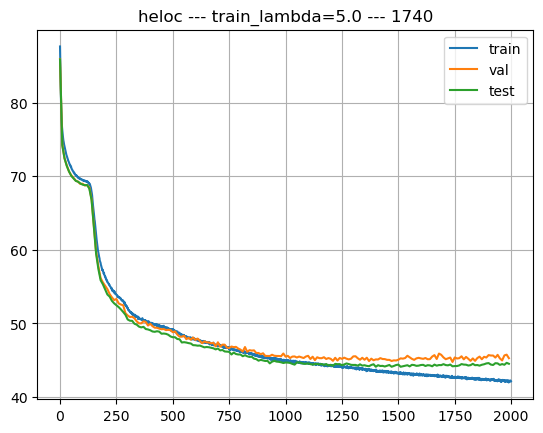

200
heloc --- train_lambda=5.0
lof 1.00±0.00
hval gold classifier 1.00±0.00
sval gold classifier 0.87±0.07
hval ann 1.00±0.00
cost 2.01±0.59
----------------------------- Executing for Dataset adult-all -----------------------------
[INFO] loaded ann model from /raid/infolab/prateekg/work/algorithmic_recourse/saved_models/classifiers/adult-all/ann_rf_tt_mm_cali_10_10_10


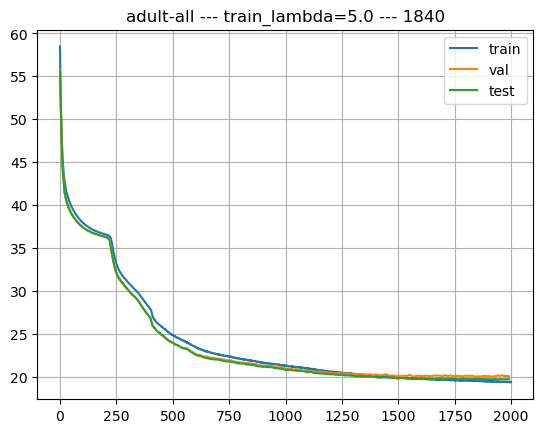

200
adult-all --- train_lambda=5.0
lof 0.98±0.12
hval gold classifier 1.00±0.00
sval gold classifier 0.91±0.12
hval ann 1.00±0.00
cost 0.69±0.30


In [7]:
for DATASET_STR in ['compas-all','heloc', 'adult-all']:
    for train_lambda in [5.0]:
        print(f"----------------------------- Executing for Dataset {DATASET_STR} -----------------------------")
        YSTAR = 1.0
        DEVICE = 'cuda:2'
        TRAIN_P = 1
        SEED = 42

        utils.set_seed(SEED)

        # load dataset
        train_y,train_X,test_y,test_X, cat_mask, immutable_mask = dutils.load_dataset(DATASET_STR, ret_tensor=True, min_max=True, ret_masks=True)
        INPUT_SHAPE = train_X.shape[1]

        LABEL_PATH =  utils.get_rf_folder(DATASET_STR,True,True)
        train_y,train_X,test_y,test_X = dutils.load_dataset(DATASET_STR, cust_labels_path=LABEL_PATH, ret_tensor=True, min_max=True)
        INPUT_SHAPE = train_X.shape[1]
        ann_clf, ann_folder = utils.load_ann(INPUT_SHAPE=INPUT_SHAPE,DATASET_STR=DATASET_STR, 
                                                LABEL_SRC='rf',**exp_config['common'],**exp_config['ann'][DATASET_STR])

        # heloc, compas-all, adult-all
        pair_model = bpm.PairedTransformerBinned(n_bins=50,
                                            num_inputs=INPUT_SHAPE,
                                            num_labels=1,
                                            num_encoder_layers=16,
                                            num_decoder_layers=16,
                                            emb_size=32,
                                            nhead=8,
                                            dim_feedforward = 32,
                                            dropout= 0.1).to(DEVICE)

        PM_STATE_PATH  = f'./saved_models/genre/{DATASET_STR}_gamma0.7/state_{train_lambda}.pth'

        state = torch.load(PM_STATE_PATH, map_location='cpu')
        pair_model.load_state_dict(state["state_dict"])
        pair_model = pair_model.to(DEVICE)
        pair_model.eval()

        loss_log = {k:state[k] for k in ('train','val','test')}
        
        fig, ax = plt.subplots()
        utils.plot_curves(ax,loss_log)

        best_epoch = state['epoch']
        ax.set_title(f'{DATASET_STR} --- {train_lambda=} --- {best_epoch}')
        plt.show()

        ann_clf = ann_clf.to(DEVICE)


        # # get negative instances
        # xf_r = rutils.get_neg_inst(ann_clf,test_X,YSTAR,sample=10000)
        # xf_r = xf_r.to(DEVICE)

        experiment_name = f'paper_experiments'
        common_dir = f"./results/{experiment_name}/{DATASET_STR}"
        with open(f"{common_dir}/xf_r", "rb") as fp:
            xf_r = pickle.load(fp).cpu()
        xf_r = xf_r.to(DEVICE)
        print(len(xf_r))
        rec_module = GenRe(pair_model=pair_model, temp=10.0, sigma=0.00, best_k=10, ann_clf=ann_clf, ystar=YSTAR, cat_mask=cat_mask)
        sample_xcf = rec_module(xf_r).squeeze()

        # yf_r = torch.ones(xf_r.shape[0]).to(DEVICE)*YSTAR

        # utils.set_seed(42)
        # sample_xcf = pair_model._sample(xf_r, yf_r, y=yf_r*0 + YSTAR, temp=10.0, sigma=0.000)
        # sample_xcf[:,cat_mask] = torch.round(sample_xcf[:,cat_mask])

        output_dir = f"{common_dir}/genre_{train_lambda}_gamma0.7"
        os.makedirs(output_dir, exist_ok=True)
        with open(f"{output_dir}/xcf", "wb") as fp:
            pickle.dump(sample_xcf.cpu(), fp)
        
        # print(output_dir)
        # print(f'------------------- sample {DATASET_STR} -------------------')

        # set up all the classifiers
        # pre-trained rf classifier
        STATE_PATH = os.path.join(LABEL_PATH, "state.pkl")
        with open(STATE_PATH, 'rb') as f:
            rf_clf = pickle.load(f)
        all_X = torch.concatenate((train_X,test_X))
        all_pred = rf_clf.predict(all_X)
        all_pred_prob = rf_clf.predict_proba(all_X) 

        # outlier factor classifier
        lof_clf = LocalOutlierFactor(n_neighbors=5, novelty=True)
        lof_clf.fit(all_X[all_pred==YSTAR])
        
        print(f'{DATASET_STR} --- {train_lambda=}')
        print('lof',utils.msstr((lof_clf.predict(sample_xcf.cpu())+1)/2,with_std=True))
        print('hval gold classifier',utils.msstr(rf_clf.predict_proba(sample_xcf.cpu())[:,int(YSTAR)]>0.5,with_std=True))
        print('sval gold classifier',utils.msstr(rf_clf.predict_proba(sample_xcf.cpu())[:,int(YSTAR)],with_std=True))
        print('hval ann',utils.msstr((ann_clf(sample_xcf)>0.5)*1.0,with_std=True))
        print('cost',utils.msstr(rutils.cost_fn(sample_xcf,xf_r), with_std=True))
        # raise